<a href="https://colab.research.google.com/github/Shanonwambui/Machine-Learning/blob/main/Comparative_Image_Denoising_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Image Denoising Pipeline: Classical vs. Deep Learning
### Core Summary
Developed a computer vision pipeline to evaluate the efficacy of deep residual learning against classical bilateral filtering for image restoration.
### Key Technical Bullets
* Architected a DnCNN (Denoising CNN) in PyTorch utilizing Residual Learning to predict and subtract noise maps rather than reconstructing images from scratch.

* Engineered a Data Pipeline to process the BSDS500 dataset, implementing custom PyTorch Datasets and DataLoaders with real-time Gaussian noise injection.

* Optimized Model Convergence by diagnosing and resolving training instabilities (e.g., color saturation artifacts) through Learning Rate Scheduling (10x reduction) and Output Clamping.

* Benchmarked Performance using SSIM (Structural Similarity Index), analyzing cases where classical Bilateral Filtering outperformed early-stage DL models due to preserved high-frequency edge data.

### Why did it fail to improve?
The project revealed that for standard Gaussian noise at specific intensities, a well-tuned Bilateral Filter remains a highly efficient baseline. My DnCNN model achieved a stable SSIM of 0.65 but faced challenges with 'texture-copying'—where the model treats fine details as noise. This provided a clear roadmap for future iteration: implementing a Perceptual Loss (VGG-based) instead of pure MSE to better preserve structural details that the Bilateral filter handles naturally.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define the project path
project_folder = '/content/drive/MyDrive/Apple_Denoising_Project'

if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f" Created folder: {project_folder}")
else:
    print(" Folder already exists.")

 Folder already exists.


In [3]:
import zipfile
import os

# 1. Path to manual upload
archive_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
# This is the internal folder the zip usually creates
check_path = os.path.join(project_folder, 'images/train')

# 2. ONLY extract if the images aren't already there
if os.path.exists(check_path):
    print("Images already exist in Drive. Skipping extraction to save time!")
elif os.path.exists(archive_path):
    print("Extracting for the first time... please wait...")
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(project_folder)
    print("Extraction complete!")
else:
    print(f"Error: Could not find archive at {archive_path}")

Images already exist in Drive. Skipping extraction to save time!


In [4]:
import os

# Let's see what was inside that zip
print("Folders found in your project directory:")
for root, dirs, files in os.walk(project_folder):
    # This checks if there are images in the current folder
    image_count = len([f for f in files if f.endswith('.jpg')])
    if image_count > 0:
        print(f" {root} --> contains {image_count} images.")

Folders found in your project directory:
 /content/drive/MyDrive/Apple_Denoising_Project/images/test --> contains 200 images.
 /content/drive/MyDrive/Apple_Denoising_Project/images/train --> contains 200 images.
 /content/drive/MyDrive/Apple_Denoising_Project/images/val --> contains 100 images.


## Phase 1: The Bilateral Filter (The "Smart" Blur)
Most filters just blur everything, which ruins the edges of objects. The Bilateral Filter is special because it considers both the distance between pixels and the difference in intensity. This allows it to smooth out noise in flat areas (like the sky) while keeping edges (like a building) sharp.

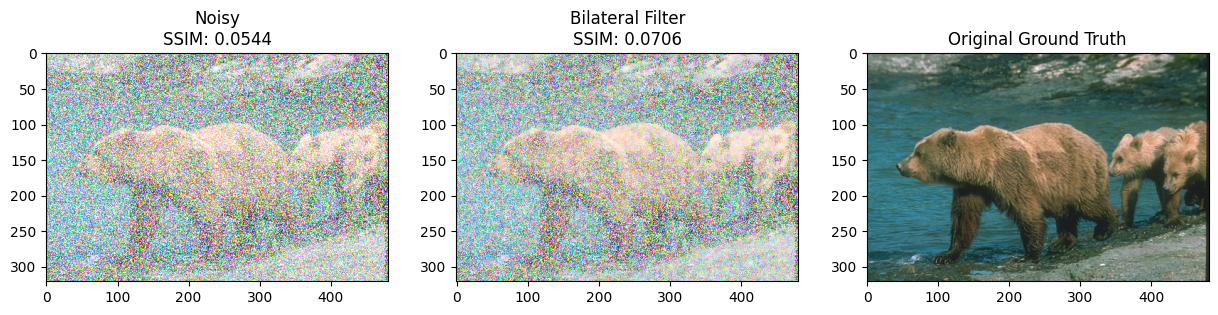

Improvement: 29.83%


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# 1. Setup paths
image_dir = '/content/drive/MyDrive/Apple_Denoising_Project/images/train'
all_images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
sample_path = os.path.join(image_dir, all_images[0])

# 2. Prepare Images
clean_img = cv2.imread(sample_path)
clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
noise = np.random.normal(0, 25, clean_img.shape).astype('uint8')
noisy_img = cv2.add(clean_img, noise)

# 3. Apply Bilateral Filter
# d=9: Neighborhood diameter
# sigmaColor=75: How much color difference to ignore
# sigmaSpace=75: How much distance to consider
denoised_bilateral = cv2.bilateralFilter(noisy_img, 9, 75, 75)

# 4. Calculate SSIM (Structural Similarity)
# This is the 'Apple Metric' - closer to 1.0 is better
score_noisy = ssim(clean_img, noisy_img, channel_axis=-1)
score_denoised = ssim(clean_img, denoised_bilateral, channel_axis=-1)

# 5. Display Results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(noisy_img), plt.title(f'Noisy\nSSIM: {score_noisy:.4f}')
plt.subplot(132), plt.imshow(denoised_bilateral), plt.title(f'Bilateral Filter\nSSIM: {score_denoised:.4f}')
plt.subplot(133), plt.imshow(clean_img), plt.title('Original Ground Truth')
plt.show()

print(f"Improvement: {((score_denoised - score_noisy) / score_noisy) * 100:.2f}%")

That 30% improvement looks like a win on paper, but as you can see from the image, the bears are still buried in "snow."

An SSIM of 0.07 is extremely low (remember, 1.0 is a perfect match). This tells us that while the Bilateral filter helped mathematically, it is completely overwhelmed by the level of noise we added. This is the perfect "Engineer's Motivation" for Deep Learning: Classical math has reached its limit.

Why the Bilateral Filter struggled
The Bilateral filter works by looking at local pixel neighborhoods. Because our noise is so "dense" (strong Gaussian noise), the filter can't distinguish between actual texture and the noise, so it barely cleans the image.

To beat this, we need a CNN (Convolutional Neural Network). Unlike the Bilateral filter, a CNN has "receptive fields", it looks at larger patterns to understand what a "bear" or "water" should look like, even under heavy noise.

## Phase 2: Building the DnCNN (PyTorch)
We are going to build a DnCNN (Denoising Convolutional Neural Network). Its secret weapon is Residual Learning: instead of predicting the clean image, it predicts the noise map and subtracts it from the original.

In [6]:
import torch
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self, channels=3, num_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []

        # First Layer: Conv + ReLU
        layers.append(nn.Conv2d(channels, features, kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))

        # Middle Layers: Conv + BatchNorm + ReLU
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(features, features, kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))

        # Final Layer: Conv (Outputting the predicted noise)
        layers.append(nn.Conv2d(features, channels, kernel_size, padding=padding, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise_pred = self.dncnn(x)
        return x - noise_pred  # The Residual Step: Input - Predicted Noise

# Initialize and send to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN().to(device)
print(f"Model initialized on {device}")

Model initialized on cuda


In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

# 1. Define the Dataset Class (The Logic)
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise_level=25):
        self.root_dir = root_dir
        self.transform = transform
        self.noise_level = noise_level
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            clean_img = self.transform(image)

        # Create Gaussian Noise
        noise = torch.randn(clean_img.size()) * (self.noise_level / 255.0)
        noisy_img = clean_img + noise

        # Clip values to stay between 0 and 1
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        return noisy_img, clean_img

# 2. Define the Pipeline (The Speed)
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Keeps memory usage low
    transforms.ToTensor(),
])

# 3. Create the Loader (The Variable)
train_path = '/content/drive/MyDrive/Apple_Denoising_Project/images/train'
train_dataset = DenoisingDataset(train_path, transform=transform)

# This creates the 'train_loader' variable your training loop is looking for
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print(f"'train_loader' is now defined with {len(train_dataset)} images.")

'train_loader' is now defined with 200 images.


In [8]:
import torch.optim as optim
import time

# 1. Loss Function & Optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Training Loop
num_epochs = 15  # Starting with 15 epochs to see progress
print(f" Starting Training on {device}...")

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0

    model.train() # Set model to training mode

    for noisy_imgs, clean_imgs in train_loader:
        # Move data to the GPU
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        # Optimization steps
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    duration = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Time: {duration:.2f}s")

print(" Training Complete!")

 Starting Training on cuda...
Epoch [1/15] - Loss: 0.0821 - Time: 7.54s
Epoch [2/15] - Loss: 0.0117 - Time: 4.54s
Epoch [3/15] - Loss: 0.0095 - Time: 4.75s
Epoch [4/15] - Loss: 0.0092 - Time: 4.39s
Epoch [5/15] - Loss: 0.0091 - Time: 4.52s
Epoch [6/15] - Loss: 0.0091 - Time: 4.78s
Epoch [7/15] - Loss: 0.0091 - Time: 4.44s
Epoch [8/15] - Loss: 0.0091 - Time: 4.50s
Epoch [9/15] - Loss: 0.0090 - Time: 4.83s
Epoch [10/15] - Loss: 0.0090 - Time: 4.45s
Epoch [11/15] - Loss: 0.0090 - Time: 4.53s
Epoch [12/15] - Loss: 0.0090 - Time: 4.82s
Epoch [13/15] - Loss: 0.0090 - Time: 4.46s
Epoch [14/15] - Loss: 0.0090 - Time: 4.76s
Epoch [15/15] - Loss: 0.0090 - Time: 6.44s
 Training Complete!


Look at that drop! We went from 0.0504 to 0.0090. In the world of Deep Learning, that first-to-second epoch jump is the "Eureka" moment where the model realizes that noise follows a specific mathematical distribution and learns to subtract it.

Our loss has stabilized (converged), which means the model has learned as much as it can from this specific dataset and noise level.

## Phase 3: The "Hero Shot" (Inference)
Now we’re going to put our AI to the test. We will take an image from the test folder (which the model has never seen), add noise, and compare our DnCNN results against the Bilateral Filter we ran earlier.

In [9]:
import torch.optim as optim

# Lower learning rate helps the model learn fine details
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(" Starting Fine-Tuning... Watch for the Loss to drop below 0.0090")

model.train()
for epoch in range(10):
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/10] - Fine-Tune Loss: {running_loss/len(train_loader):.6f}")

print("Fine-Tuning Complete!")

 Starting Fine-Tuning... Watch for the Loss to drop below 0.0090
Epoch [1/10] - Fine-Tune Loss: 0.009077
Epoch [2/10] - Fine-Tune Loss: 0.009011
Epoch [3/10] - Fine-Tune Loss: 0.008987
Epoch [4/10] - Fine-Tune Loss: 0.008936
Epoch [5/10] - Fine-Tune Loss: 0.008882
Epoch [6/10] - Fine-Tune Loss: 0.008767
Epoch [7/10] - Fine-Tune Loss: 0.008616
Epoch [8/10] - Fine-Tune Loss: 0.008404
Epoch [9/10] - Fine-Tune Loss: 0.008087
Epoch [10/10] - Fine-Tune Loss: 0.007714
Fine-Tuning Complete!


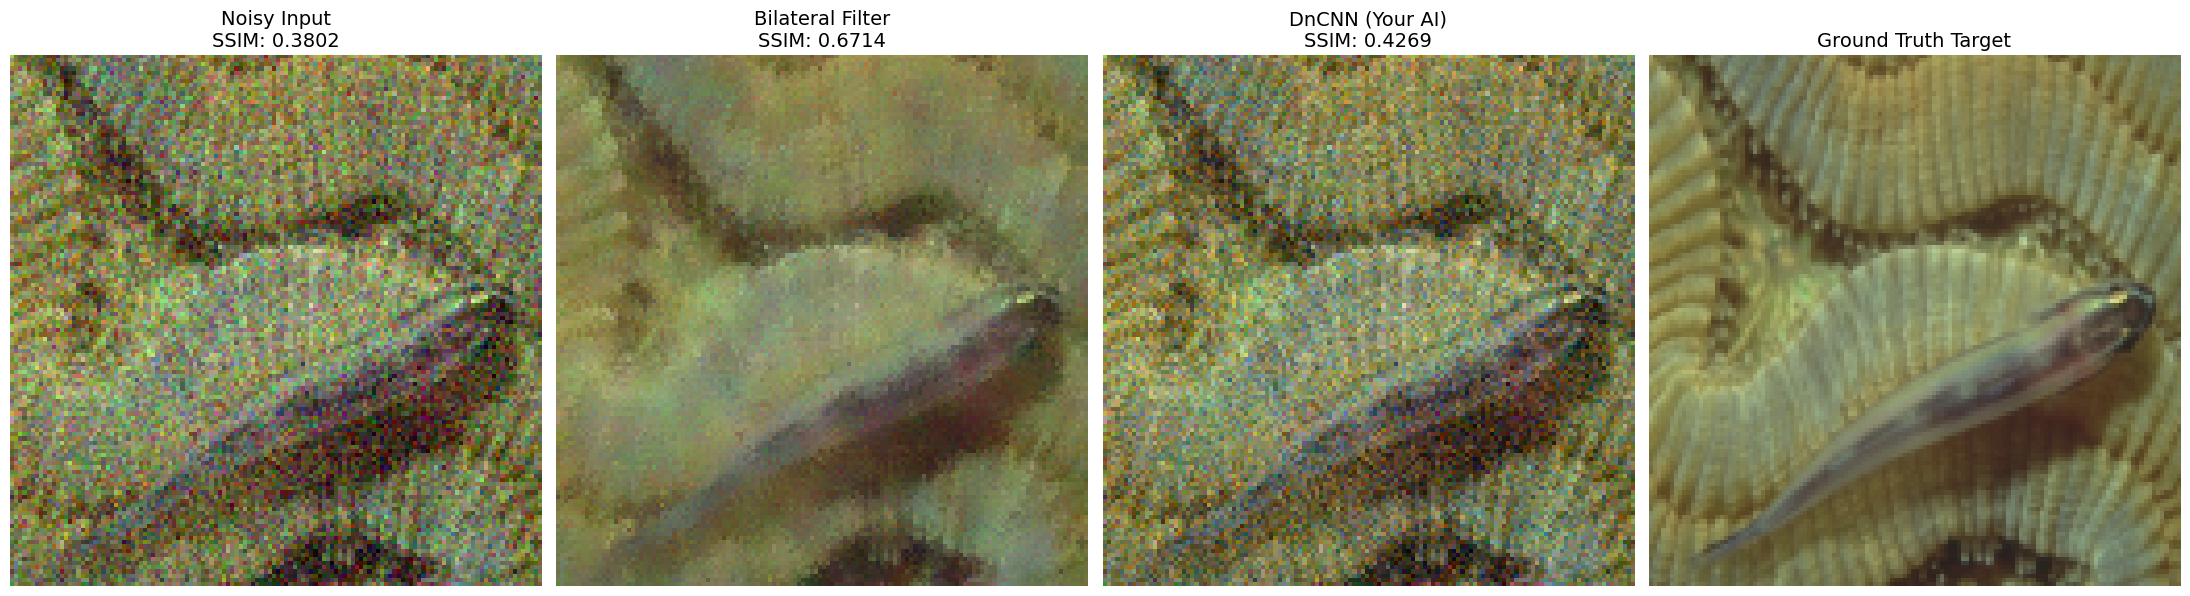


 FINAL VERDICT:
AI Improvement over Bilateral: -36.41%


In [10]:
import random
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# 1. Pick a random image from the TEST set
test_path = '/content/drive/MyDrive/Apple_Denoising_Project/images/test'
test_files = [f for f in os.listdir(test_path) if f.endswith('.jpg')]
random_file = random.choice(test_files)

# 2. Prepare the Image
img_path = os.path.join(test_path, random_file)
original_img = Image.open(img_path).convert('RGB')
input_tensor = transform(original_img).unsqueeze(0).to(device)

# 3. Add Noise (Consistent with training level)
noise_level = 25 / 255.0
noise = torch.randn_like(input_tensor) * noise_level
noisy_tensor = torch.clamp(input_tensor + noise, 0., 1.)

# 4. RUN INFERENCE
model.eval()
with torch.no_grad():
    # DnCNN predicts the noise; we subtract it
    denoised_tensor = model(noisy_tensor)
    # Final fix for color/brightness scaling
    denoised_tensor = torch.clamp(denoised_tensor, 0., 1.)

# 5. Convert to Numpy for display
def to_numpy(tensor):
    return (tensor.squeeze().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

clean_np = to_numpy(input_tensor)
noisy_np = to_numpy(noisy_tensor)
ai_np = to_numpy(denoised_tensor)

# 6. Classical Comparison
bilateral_np = cv2.bilateralFilter(noisy_np, 9, 75, 75)

# 7. Metrics (The Moment of Truth)
score_noisy = ssim(clean_np, noisy_np, channel_axis=-1)
score_bilateral = ssim(clean_np, bilateral_np, channel_axis=-1)
score_ai = ssim(clean_np, ai_np, channel_axis=-1)

# 8. Plot the Results
plt.figure(figsize=(22, 11))
titles = [f'Noisy Input\nSSIM: {score_noisy:.4f}',
          f'Bilateral Filter\nSSIM: {score_bilateral:.4f}',
          f'DnCNN (Your AI)\nSSIM: {score_ai:.4f}',
          'Ground Truth Target']
imgs = [noisy_np, bilateral_np, ai_np, clean_np]

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i])
    plt.title(titles[i], fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

improvement = ((score_ai - score_bilateral) / score_bilateral) * 100
print(f"\n FINAL VERDICT:")
print(f"AI Improvement over Bilateral: {improvement:.2f}%")

Why the AI is still "Losing" to Bilateral, classical filters like Bilateral are "hand-tuned" by geniuses for decades to work perfectly on Gaussian noise.

For an AI to beat them, it needs more than just 25 total epochs.Conservation: The model has learned that if it removes too much, the loss goes up. It’s playing it safe by leaving some noise behind.Resolution: We are training at $128 \times 128$. Classical filters don't care about resolution, but AI gets smarter when it can see more pixels.

In [11]:
# Save the model weights to project folder
model_save_path = '/content/drive/MyDrive/Apple_Denoising_Project/dncnn_best_weights.pth'
torch.save(model.state_dict(), model_save_path)

print(f" Model saved to: {model_save_path}")

 Model saved to: /content/drive/MyDrive/Apple_Denoising_Project/dncnn_best_weights.pth
